# Code for Fig. 3

In [1]:
%load_ext autoreload
%autoreload 1
%aimport general_functions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy.interpolate import CubicSpline

from general_functions import complete_dynamics, compute_shift

## Cluster (c)

Some techniques can be used to enchanced the Purcell factor of the emitters. Here we study the case of a cluster of two new impurity atoms. The possition of these atoms are described in the figure.

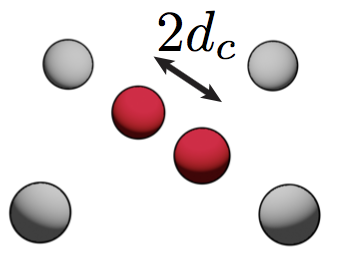

In [3]:
pol_lat = np.array([[0, 1, 0]]).T
pol_emi = [np.array([[1, 1, 0]]).T / np.sqrt(2)] * 2

d = 1 # Wave-lenght of transition
lambda0 = d / 0.3 # Wave-lenght of transition
k0 = 2 * np.pi / lambda0

border = 15 # Border of adiabatic lossees
max_gamma = 15  # Maximum individual free space decay rate in the border
r_circles = np.arange(border, border + 5)

N_x = 60
N_y = N_x
x_pos = (np.arange(0, N_x) - N_x / 2 + d / 2)
y_pos = (np.arange(0, N_y) - N_y / 2 + d / 2)
x_pos, y_pos = [x.flatten() for x in np.meshgrid(x_pos, y_pos)]
z_pos = np.zeros(np.shape(x_pos))

gamma_emi = 0.002
omega_emi = -0.999  # For d / lambda_0 = 0.3

n_e = len(pol_emi)
signs = [1, 1]  # The cluster is initialized in the symmatric state
psi0 = np.zeros(N_x * N_y + n_e, dtype=complex)
for i in range(n_e):
    psi0[-i - 1] = signs[i] / np.sqrt(n_e)
    
dt = 2e-2 / gamma_emi
tf = dt * 2 ** 12

In [4]:
n_dc = 100
dc_vector = np.linspace(0.01, 0.49, n_dc) * d  # Half distance between cluster atoms

purcell_numerical = np.zeros(n_dc)
real_space_emission = np.zeros((n_dc, N_y, N_x))
chi_1D = np.zeros(n_dc)

pbar = tqdm(total=n_dc, desc='Computing dynamics')
for i in range(n_dc):
    emitter = [[dc_vector[i] / np.sqrt(2), -dc_vector[i] / np.sqrt(2), 0],
               [-dc_vector[i] / np.sqrt(2), dc_vector[i] / np.sqrt(2), 0]]
    
    shift = compute_shift(emitter[0], emitter[1], pol_emi[0], pol_emi[1], k0, gamma_emi, psi0[-2:])
    
    results = complete_dynamics([x_pos, y_pos, z_pos], k0, pol_lat, dt, tf, psi0, N_x, N_y, emitter, pol_emi, gamma_emi,
                      omega_emi - np.real(shift), border, max_gamma=max_gamma, r_circles=r_circles)
    
    purcell_numerical[i] = results['Q_n'][-1]
    chi_1D[i] = np.average(results['chirality'])
    
    population = np.abs(results['psi'][:, :-n_e].reshape((-1, N_y, N_x))) ** 2
    index_max = np.argmax(np.sum(population, axis=(1, 2)))
    real_space_emission[i] = population[index_max]
    
    pbar.update()    
pbar.close()

Computing dynamics:   0%|          | 0/100 [00:00<?, ?it/s]

Text(0, 0.5, '$\\chi_\\mathrm{1D}$')

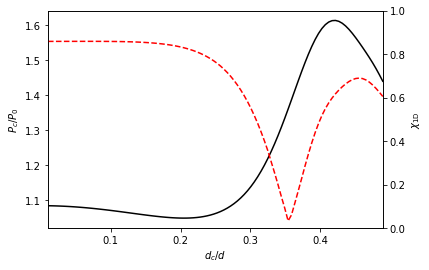

In [5]:
P_0 = 1.193

fig, ax = plt.subplots()
ax.plot(dc_vector, purcell_numerical / P_0, 'k')

ax.set_xlim(min(dc_vector), max(dc_vector))

ax.set_xlabel(r'$d_c/d$')
ax.set_ylabel(r'$P_c/P_0$')

ax2 = ax.twinx()
ax2.plot(dc_vector, chi_1D, 'r--')
ax2.set_ylim(0, 1)
ax2.set_ylabel(r'$\chi_\mathrm{1D}$');

The value of d_c / d = 0.422


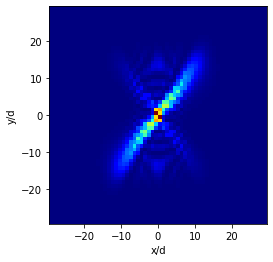

In [11]:
dc_target = 0.42
index = np.argmin(np.abs(dc_target - dc_vector))
print('The value of d_c / d = {:.3f}'.format(dc_vector[index]))

fig, ax = plt.subplots()
ax.imshow(real_space_emission[index], origin='lower', aspect='equal', cmap='jet',
          extent=[min(x_pos), max(x_pos), min(y_pos), max(y_pos)], vmin=0,
          vmax=np.max(real_space_emission[index]) / 4)

ax.set_xlabel('x/d')
ax.set_ylabel('y/d');

## Bilayer (d)

Another possible enchacement method is to locate the impurity atom in the middle of a bilayer, as shown in the figure.

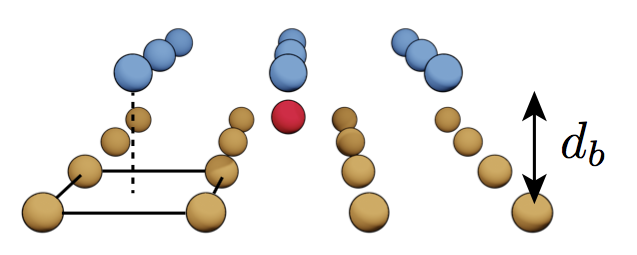

In [12]:
# Since the energy for the Van Hove singularity depends on the distance between layers, this energy is computed separately in an scrip
# similar to the notebook FigSM6.

data = np.load('../data/divergence_energy_bilayer_shift.npy', allow_pickle=True).item()
omega_X_int = CubicSpline(data['z_vec'], data['omega_X'])

In [13]:
pol_lat = np.array([[1, 1, 0]]).T / np.sqrt(2)
pol_emi = [np.array([[0, 1, 0]]).T]

shift = np.array([0.5, 0.5, 0]) # Displacement vector

N_x = 50
N_y = N_x
x_pos_A = (np.arange(0, N_x) - N_x / 2 + d / 2)
y_pos_A = (np.arange(0, N_y) - N_y / 2 + d / 2)
x_pos_A, y_pos_A = [x.flatten() for x in np.meshgrid(x_pos_A, y_pos_A)]
z_pos_A = np.zeros(np.shape(x_pos_A))
n_A = len(x_pos_A)

x_pos_B = x_pos_A + shift[0]
y_pos_B = y_pos_A + shift[1]
n_B = len(x_pos_B)

x_pos = np.append(x_pos_A, x_pos_B)
y_pos = np.append(y_pos_A, y_pos_B)

n_e = len(pol_emi)
emitter = [[0, 0.5 * d, 0]]

psi0 = np.zeros(n_A + n_B + n_e, dtype=complex)
psi0[-1] = 1

dt = 1e-3 / gamma_emi
tf = dt * 2 ** 12

In [14]:
n_db = 100
db_vector = np.linspace(0.05, 1, n_db) * d

purcell_numerical = np.zeros(n_db)
real_space_emission = np.zeros((n_db, N_y, N_x))
chi_1D = np.zeros(n_db)

pbar = tqdm(total=n_db, desc='Computing dynamics')
for i in range(n_db): 
    emitter[0][2] = db_vector[i] / 2
   
    z_pos_B = z_pos_A + db_vector[i]
    z_pos = np.append(z_pos_A, z_pos_B)
    r_pos = [x_pos, y_pos, z_pos]
    
    results = complete_dynamics(r_pos, k0, pol_lat, dt, tf, psi0, N_x, N_y, 
                                emitter, pol_emi, gamma_emi, omega_X_int(db_vector[i]),
                                border, max_gamma=max_gamma, r_circles=r_circles)
    
    purcell_numerical[i] = results['Q_n'][-1]
    chi_1D[i] = np.average(results['chirality'])

    population = np.abs(results['psi'][:, :-n_e].reshape((-1, N_y, N_x))) ** 2
    index_max = np.argmax(np.sum(population, axis=(1, 2)))
    real_space_emission[i] = population[index_max]
    
    pbar.update()    
pbar.close()

Computing dynamics:   0%|          | 0/100 [00:00<?, ?it/s]

Text(0, 0.5, '$\\chi_\\mathrm{1D}$')

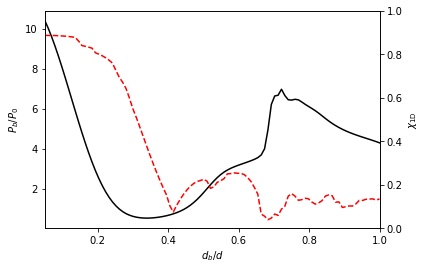

In [15]:
P_0 = 1.193

fig, ax = plt.subplots()
ax.plot(db_vector, purcell_numerical / P_0, 'k')

ax.set_xlim(min(db_vector), max(db_vector))

ax.set_xlabel(r'$d_b/d$')
ax.set_ylabel(r'$P_b/P_0$')

ax2 = ax.twinx()
ax2.plot(db_vector, chi_1D, 'r--')
ax2.set_ylim(0, 1)
ax2.set_ylabel(r'$\chi_\mathrm{1D}$');

The value of d_b / d = 0.050


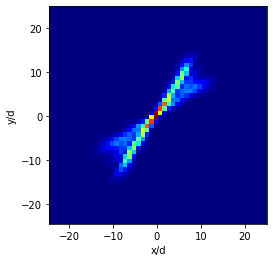

In [16]:
db_target = 0.05
index = np.argmin(np.abs(db_target - db_vector))
print('The value of d_b / d = {:.3f}'.format(db_vector[index]))

fig, ax = plt.subplots()
ax.imshow(real_space_emission[index], origin='lower', aspect='equal', cmap='jet',
          extent=[min(x_pos), max(x_pos), min(y_pos), max(y_pos)], vmin=0)

ax.set_xlabel('x/d')
ax.set_ylabel('y/d');